Notebook to make the 2 moons example from the normalizing flow section of the paper

In [1]:
from pzflow import Flow
from pzflow.bijectors import RollingSplineCoupling
from pzflow.examples import two_moons_data

import jax.numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as onp

from sklearn.datasets import make_moons

In [2]:
moons = make_moons(n_samples=100000, noise=0.05, random_state=0)[0]

In [3]:
xm, ym = moons[:,0], moons[:,1]

In [4]:
xm = (xm - xm.mean()) / xm.std()
ym = (ym - ym.mean()) / ym.std()

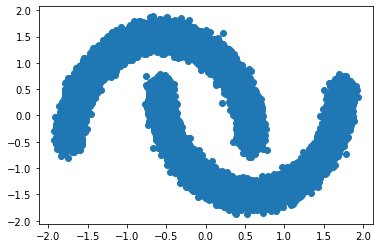

In [5]:
plt.scatter(xm, ym)

In [6]:
# plotting style
plt.style.use('paper.mplstyle')
twocol = 7.1014
onecol = 3.35

First let's load some example data. It's the familiar two moons data set from scikit-learn, loaded in a Pandas DataFrame, which is the data format `pzflow` uses on the user-end.

In [7]:
#data = two_moons_data()
data = pd.DataFrame(np.array([xm, ym]).T, columns=("x", "y"))
data

,x,y
0,0.655471,0.009298
1,-0.348526,-0.644968
2,-0.570777,0.001651
3,-0.332232,1.613281
4,0.451780,-0.151889
...,...,...
99995,-0.309455,1.402111
99996,-1.697351,0.057418
99997,-1.579294,0.421445
99998,-1.659075,0.179984


Let's plot it to see what it looks like.

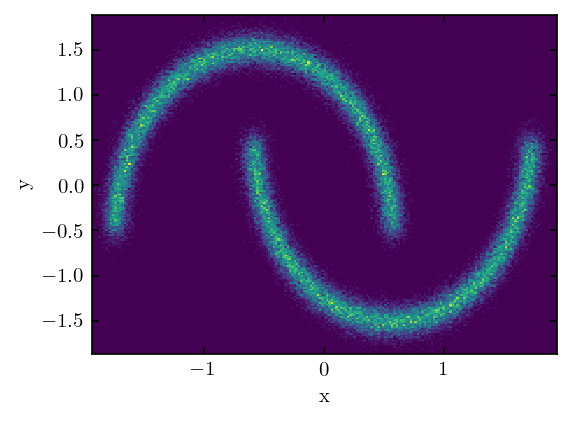

In [8]:
fig = plt.figure(figsize=(4, 3))
plt.hist2d(data['x'], data['y'], bins=200)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Now let's build a normalizing flow.

In [9]:
# set number of layers in the RollingSplineCoupling
# equal to the input dimension
nlayers = data.shape[1]

# create the bijector
bijector = RollingSplineCoupling(nlayers=nlayers, K=256, B=5)

# create the normalizing flow
flow = Flow(data.columns, bijector)

Now we can train our normalizing flow.
This is as simple as calling `flow.train(data)`.
There are several training parameters you can set, including the number of epochs, the batch size, the optimizer, and the random seed.
See the documentation for the normalizing flow for more details.
For this example, let's use the defaults, but set `verbose=True` so that training losses are printed throughout the training process.

In [10]:
%%time
losses = flow.train(data, verbose=True)

Training 50 epochs 
Loss:
2.8627
2.1527
1.4176
1.2497
1.2297
1.2338
1.3577
1.2501
1.1737
1.2440
1.2094
1.1917
1.1635
1.1812
1.2416
1.2596
1.1633
1.1538
1.1686
1.1718
1.1684
1.1831
1.2071
1.1820
1.1673
1.1824
CPU times: user 41min 19s, sys: 40min 20s, total: 1h 21min 40s
Wall time: 11min 14s


Now let's plot the training losses to make sure everything looks like we expect it to...

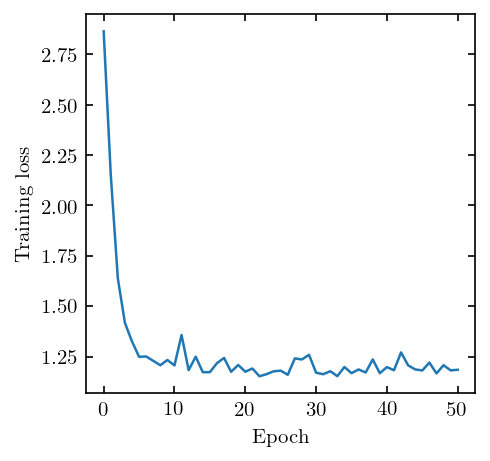

In [11]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Training loss")
plt.show()

Perfect!

Now we can draw samples from the flow, using the `sample` method.
Let's draw 10000 samples and make another histogram to see if it matches the data.

In [12]:
samples = flow.sample(10000, seed=0)

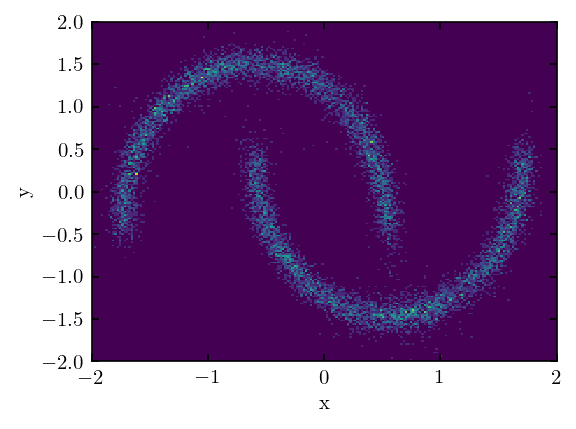

In [13]:
fig = plt.figure(figsize=(4, 3))
plt.hist2d(samples['x'], samples['y'], bins=200, range=((-2,2),(-2,2)))
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [14]:
xmax = 2.5
dx = 0.1
grid = np.arange(-xmax, xmax+dx, dx)
x, y = np.meshgrid(grid, grid)
x, y = x.flatten(), y.flatten()

conditions = np.zeros((x.size, 1))

grid_fwd = flow._forward(flow._params[1], np.array([x, y]).T, conditions=conditions)[0]
x_fwd, y_fwd = grid_fwd[:, 0], grid_fwd[:, 1]

grid_inv = flow._inverse(flow._params[1], np.array([x, y]).T, conditions=conditions)[0]
x_inv, y_inv = grid_inv[:, 0], grid_inv[:, 1]

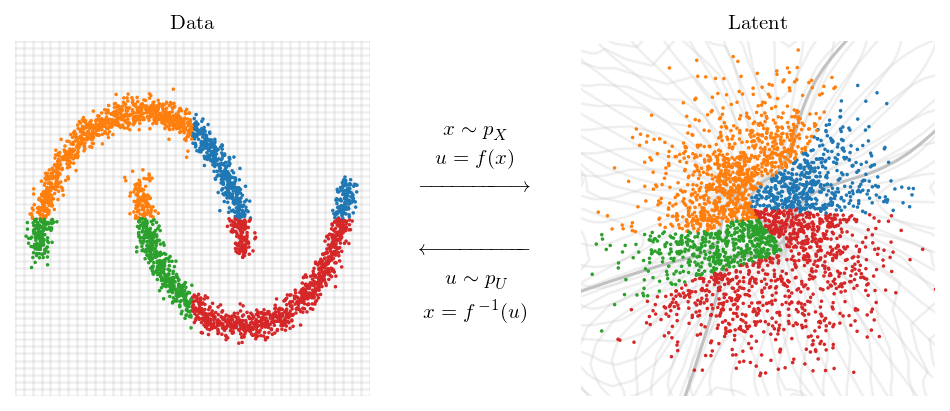

In [41]:
# set up the figure
xpad = 0.02
top_pad = 0.1
bottom_pad = 0.05
xfrac = 0.37
yfrac = 1 - top_pad - bottom_pad
figW = 0.9 * twocol
figH = xfrac * figW / yfrac
fig = plt.figure(figsize=(figW, figH))

# create the axes
wmid = 1 - 2*xpad - 2*xfrac
ax1 = fig.add_axes([xpad, bottom_pad, xfrac, yfrac])
ax2 = fig.add_axes([xpad + xfrac, bottom_pad, wmid, yfrac])
ax3 = fig.add_axes([xpad + xfrac + wmid, bottom_pad, xfrac, yfrac])

# define function to draw grid
def plot_grid(ax, x, y):
    assert x.shape == y.shape
    d = int(np.sqrt(x.shape[0]))
    x_, y_ = x.reshape(d,d), y.reshape(d,d)
    ax.plot(x_, y_, c="silver", alpha=0.25, zorder=0)
    ax.plot(y_, x_, c="silver", alpha=0.25, zorder=0)

# turn off all axes
ax1.axis("off")
ax2.axis("off")
ax3.axis("off")

# set axis limits
ax1.set(xlim=(-2, 2), ylim=(-2.5, 2.5))
ax2.set(xlim=(0, 1), ylim=(0,1))
ax3.set(xlim=(-3.2, 3.2), ylim=(-3.2, 3.2))

# define colors for scatter plot
def map_colors(x, y):
    c = onp.zeros(x.size, dtype=int)
    c[(x < 0) & (y > 0)] = 1
    c[(x < 0) & (y < 0)] = 2
    c[(x > 0) & (y < 0)] = 3
    return [f"C{i}" for i in c]

# number of points to plot
N = 3000

# two moons scatter with grid
ax1.set(title="Data")
plot_grid(ax1, x, y)
x_, y_ = data["x"][:N], data["y"][:N]
c = map_colors(x_, y_)
ax1.scatter(x_, y_, c=c, s=0.5, rasterized=True)

# Gaussian scatter with grid
ax3.set(title="Latent")
plot_grid(ax3, x_fwd, y_fwd)
conditions = np.zeros((N, 1))
data_fwd = flow._forward(flow._params[1], data.values[:N], conditions=conditions)[0]
x_, y_ = data_fwd[:, 0], data_fwd[:, 1]
ax3.scatter(x_, y_, c=c[:N], s=0.5, rasterized=True)

# text in the middle
yd = 0.17
ax2.text(0.50, 0.58+yd, "$x \sim p^{}_{X}$", ha="center", va="center")
ax2.text(0.50, 0.50+yd, "$u = f(x)$", ha="center", va="center")
ax2.text(0.50, 0.42+yd, "$-\!\!\!-\!\!\!-\!\!\!-\!\!\!-\!\!\!-\!\!\!-\!\!\!-\!\!\! \longrightarrow$", ha="center", va="center")

ax2.text(0.50, 0.58-yd, "$\longleftarrow\!\!\!-\!\!\!-\!\!\!-\!\!\!-\!\!\!-\!\!\!-\!\!\!-\!\!\!-$", ha="center", va="center")
ax2.text(0.50, 0.50-yd, "$u \sim p^{}_{U}$", ha="center", va="center")
ax2.text(0.50, 0.41-yd, "$x = f^{\,-1}(u)$", ha="center", va="center")

fig.savefig("two-moons-example.pdf")
plt.show()

--------------------

In [ ]:
xmax = 4
dx = 0.1
grid = np.arange(-xmax, xmax+dx, dx)
x, y = np.meshgrid(grid, grid)
x, y = x.flatten(), y.flatten()

conditions = np.zeros((x.size, 1))

grid_fwd = flow._forward(flow._params[1], np.array([x, y]).T, conditions=conditions)[0]
x_fwd, y_fwd = grid_fwd[:, 0], grid_fwd[:, 1]

grid_inv = flow._inverse(flow._params[1], np.array([x, y]).T, conditions=conditions)[0]
x_inv, y_inv = grid_inv[:, 0], grid_inv[:, 1]

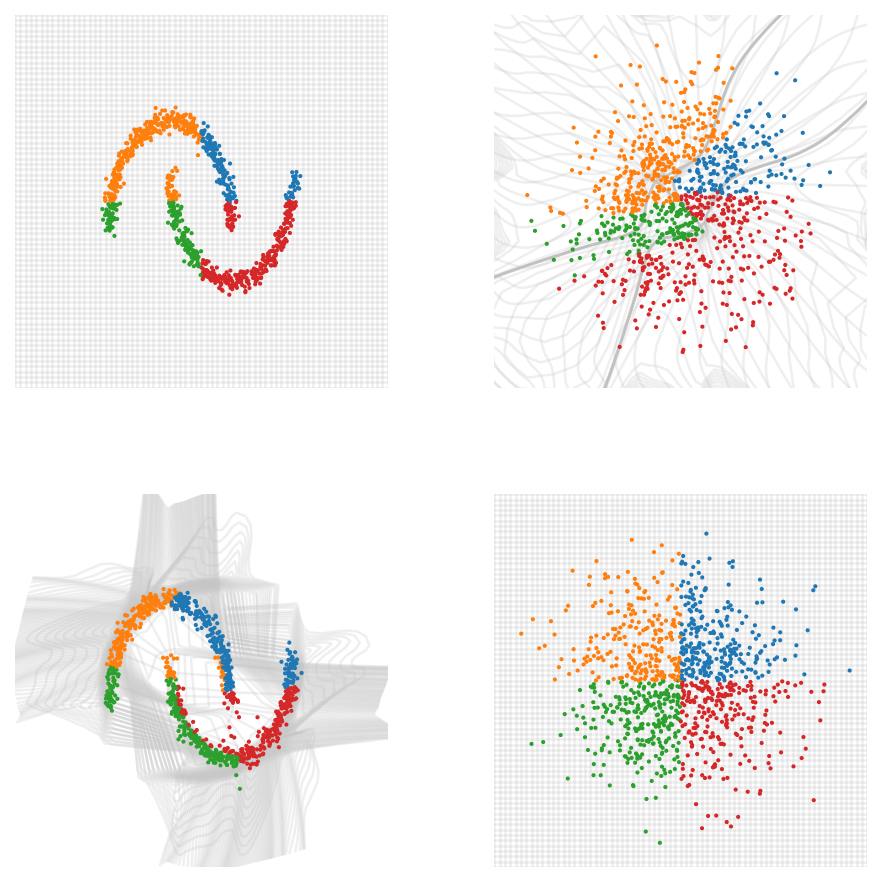

In [127]:
fig = plt.figure(figsize=(twocol, twocol))

ax1 = fig.add_axes([0.10, 0.55, 0.35, 0.35])
ax2 = fig.add_axes([0.55, 0.55, 0.35, 0.35])
ax3 = fig.add_axes([0.10, 0.10, 0.35, 0.35])
ax4 = fig.add_axes([0.55, 0.10, 0.35, 0.35])
    
def plot_grid(ax, x, y):
    assert x.shape == y.shape
    d = int(np.sqrt(x.shape[0]))
    x_, y_ = x.reshape(d,d), y.reshape(d,d)
    ax.plot(x_, y_, c="silver", alpha=0.25, zorder=0)
    ax.plot(y_, x_, c="silver", alpha=0.25, zorder=0)
    
axes = [ax1, ax2, ax3, ax4]
for ax in axes:
    L = 3.5
    ax.set(xlim=(-L, L), ylim=(-L, L))
    ax.axis("off")
    
def map_colors(x, y):
    c = onp.zeros(x.size, dtype=int)
    c[(x < 0) & (y > 0)] = 1
    c[(x < 0) & (y < 0)] = 2
    c[(x > 0) & (y < 0)] = 3
    return [f"C{i}" for i in c]


N = 1000

# top left
plot_grid(ax1, x, y)
x_, y_ = data["x"][:N], data["y"][:N]
c = map_colors(x_, y_)
ax1.scatter(x_, y_, c=c, s=1)

# top right
plot_grid(ax2, x_fwd, y_fwd)
conditions = np.zeros((N, 1))
data_fwd = flow._forward(flow._params[1], data.values[:N], conditions=conditions)[0]
x_, y_ = data_fwd[:, 0], data_fwd[:, 1]
ax2.scatter(x_, y_, c=c[:N], s=1)

# bottom right
plot_grid(ax4, x, y)
onp.random.seed(0)
samples = onp.random.normal(size=(N, 2))
x_, y_ = samples[:, 0], samples[:, 1]
c = map_colors(x_, y_)
ax4.scatter(x_, y_, c=c, s=1)

# bottom left
plot_grid(ax3, x_inv, y_inv)
data_inv = flow._inverse(flow._params[1], samples, conditions=conditions)[0]
x_, y_ = data_inv[:, 0], data_inv[:, 1]
ax3.scatter(x_, y_, c=c, s=1)

plt.show()